# Contact Classification

Download data from: https://utexas.box.com/s/5tvy96e01yett9kqdu5htdsvn9q6dtyc  
_Requires a UT account_  
Place the downloaded data in a folder `data/`

## Import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

## Parse data

### Read files

In [2]:
file_pattern = "*.csv"
data_path = os.fspath("data/oct22_data")
data_files = glob.glob(file_pattern, root_dir=data_path)
print(f"Found {len(data_files)} data files")

Found 30 data files


### Append data files to Pandas dataframe

In [3]:
df_list = []
for file_name in data_files:
    file = os.path.join(data_path,file_name)
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)
data_raw = pd.concat(df_list)
display(data_raw)
display(data_raw.dtypes)

,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_1.2841m (µε),strain_0.0800m (µε).1,strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),strain_0.0826m (µε),...,strain_1.2799m (µε),strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,2.178,0.00,-0.093994,-0.3,0.5,-0.3,-7.5,5.8,8.0,-7.5,...,-9.200000,-17.900000,-7.900000,10.1,9.0,3.5,5.1,0.7,4.4,0.5
1,2.440,0.00,-0.068848,10.6,5.3,10.6,1.5,2.1,-5.3,-2.0,...,-0.200000,-18.700000,-2.500000,5.4,6.3,-4.4,0.6,2.4,0.9,5.3
2,2.857,0.00,-0.029297,10.7,7.4,10.7,-8.0,0.5,-6.0,-4.9,...,-0.300000,-10.700000,-6.600000,10.3,7.4,0.1,5.6,4.5,2.3,7.4
3,3.193,0.00,0.002930,10.7,3.3,10.7,-0.8,2.0,-6.0,-2.3,...,-2.700000,-16.700000,-22.299999,12.4,4.8,2.9,7.9,13.1,5.8,3.3
4,3.453,0.00,0.027588,-0.3,11.0,-0.3,-5.8,0.5,0.3,2.7,...,0.300000,-21.099999,-4.700000,21.5,10.5,4.9,7.6,7.4,3.7,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,10.213,0.00,-5.305908,1.1,-4.5,1.1,4.9,1.3,2.1,1.6,...,0.500000,-5.000000,-6.200000,-0.1,-3.3,-0.4,-14.9,-3.4,-11.1,-4.5
1,10.666,0.00,-5.262695,-4.4,5.3,-4.4,1.6,2.6,-0.4,-2.0,...,-3.200001,-0.600000,-1.700000,-6.7,7.4,-14.4,-10.5,1.1,-0.2,5.3
2,10.974,-0.01,-5.233154,-3.6,-3.8,-3.6,9.9,4.1,-6.1,-4.6,...,-1.000000,1.500000,2.700000,3.2,9.8,-2.7,-13.7,0.7,-9.0,-3.8
3,11.234,0.00,-5.208252,-4.0,-9.0,-4.0,2.0,0.4,-6.6,-8.6,...,-0.800000,5.099999,-4.500000,-2.7,3.7,-11.4,-9.1,1.9,-2.4,-9.0


Time (s.ms)             float64
Force_gauge (N)         float64
Linear_position (mm)    float64
strain_0.0800m (µε)     float64
strain_1.2841m (µε)     float64
                         ...   
strain_1.2831m (µε)     float64
strain_1.2838m (µε)     float64
strain_1.2845m (µε)     float64
strain_1.2851m (µε)     float64
strain_1.2858m (µε)     float64
Length: 1861, dtype: object

### Remove extra gauges and sort by position along sensor

In [4]:
data = data_raw.loc[:, ~data_raw.columns.str.contains(r"\.\d+$")]

strain_cols = [col for col in data.columns if col.startswith("strain")]
other_cols = [col for col in data.columns if col not in strain_cols]

x_axis_raw = np.array([float(re.search(r"strain_(.*)m", x).group(1)) for x in strain_cols])
sorted_idx = np.argsort(x_axis_raw)
x_axis = np.sort(x_axis_raw)
sorted_strain_cols = [strain_cols[i] for i in sorted_idx]
data = data[other_cols + sorted_strain_cols]
display(data)

,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),strain_0.0826m (µε),strain_0.0833m (µε),strain_0.0839m (µε),...,strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2841m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,2.178,0.00,-0.093994,-0.3,-7.5,5.8,8.0,-7.5,-10.7,5.4,...,-17.900000,-7.900000,10.1,9.0,3.5,5.1,0.5,0.7,4.4,0.5
1,2.440,0.00,-0.068848,10.6,1.5,2.1,-5.3,-2.0,-3.2,8.9,...,-18.700000,-2.500000,5.4,6.3,-4.4,0.6,5.3,2.4,0.9,5.3
2,2.857,0.00,-0.029297,10.7,-8.0,0.5,-6.0,-4.9,-1.3,4.2,...,-10.700000,-6.600000,10.3,7.4,0.1,5.6,7.4,4.5,2.3,7.4
3,3.193,0.00,0.002930,10.7,-0.8,2.0,-6.0,-2.3,-1.4,-5.2,...,-16.700000,-22.299999,12.4,4.8,2.9,7.9,3.3,13.1,5.8,3.3
4,3.453,0.00,0.027588,-0.3,-5.8,0.5,0.3,2.7,-6.1,-1.8,...,-21.099999,-4.700000,21.5,10.5,4.9,7.6,11.0,7.4,3.7,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,10.213,0.00,-5.305908,1.1,4.9,1.3,2.1,1.6,0.5,-0.9,...,-5.000000,-6.200000,-0.1,-3.3,-0.4,-14.9,-4.5,-3.4,-11.1,-4.5
1,10.666,0.00,-5.262695,-4.4,1.6,2.6,-0.4,-2.0,3.1,11.1,...,-0.600000,-1.700000,-6.7,7.4,-14.4,-10.5,5.3,1.1,-0.2,5.3
2,10.974,-0.01,-5.233154,-3.6,9.9,4.1,-6.1,-4.6,0.8,-2.0,...,1.500000,2.700000,3.2,9.8,-2.7,-13.7,-3.8,0.7,-9.0,-3.8
3,11.234,0.00,-5.208252,-4.0,2.0,0.4,-6.6,-8.6,-0.9,4.2,...,5.099999,-4.500000,-2.7,3.7,-11.4,-9.1,-9.0,1.9,-2.4,-9.0


## Data Processing

### Visualize strain ranges

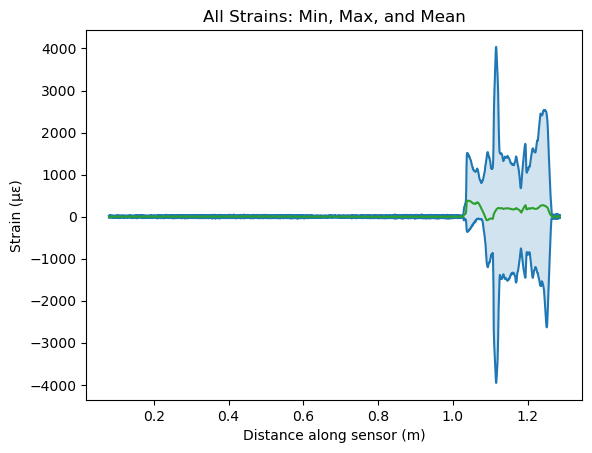

In [5]:
upper_bound = data[sorted_strain_cols].max()
lower_bound = data[sorted_strain_cols].min()
mean_line = data[sorted_strain_cols].mean()

fig, ax = plt.subplots()
ax.plot(x_axis,upper_bound,color='tab:blue')
ax.plot(x_axis,lower_bound,color='tab:blue')
ax.plot(x_axis,mean_line,color='tab:green')
ax.fill_between(x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("All Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Cutoff excess early data

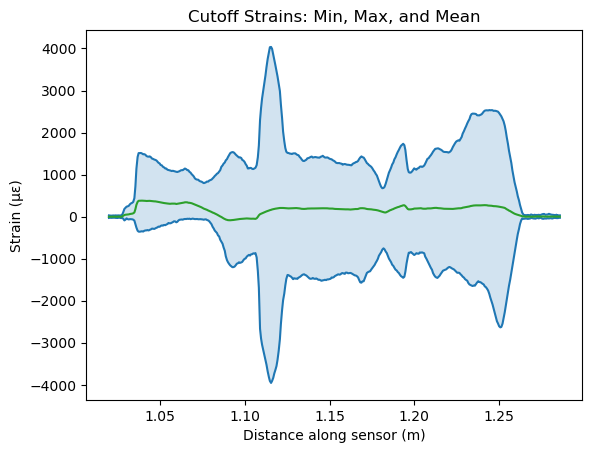

In [6]:
start_location = 1.02
cutoff_idx = (np.abs(x_axis - start_location)).argmin()
cutoff_strain = data[sorted_strain_cols].iloc[:,cutoff_idx:]
cutoff_x_axis = x_axis[cutoff_idx:]

upper_bound = cutoff_strain.max()
lower_bound = cutoff_strain.min()
mean_line = cutoff_strain.mean()

fig, ax = plt.subplots()
ax.plot(cutoff_x_axis,upper_bound,color='tab:blue')
ax.plot(cutoff_x_axis,lower_bound,color='tab:blue')
ax.plot(cutoff_x_axis,mean_line,color='tab:green')
ax.fill_between(cutoff_x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("Cutoff Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Remove NAN Values

In [7]:
display(cutoff_strain.isna().sum().sum())
cutoff_strain.interpolate(inplace=True)
display(cutoff_strain.isna().sum().sum())


280

0

### Create Classification Labels

In [8]:
force_threshold = 0.01
contact_data = pd.DataFrame({"Contact": (data['Force_gauge (N)'] >= force_threshold).astype(int)})
display(contact_data.sum())

Contact    1195
dtype: int64

## Train Model

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, KFold
model = GradientBoostingClassifier()
folds = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_validate(model, cutoff_strain, contact_data.to_numpy().squeeze(), 
                        cv=folds, scoring=['precision','recall'], n_jobs = -1)

print("Precision scores:", scores['test_precision'])
print("Recall scores:", scores['test_recall'])
print("Avg Precision:", scores['test_precision'].mean())
print("Avg Recall:", scores['test_recall'].mean())

Precision scores: [0.95121951 0.92982456 0.9587156  0.93953488 0.96226415]
Recall scores: [0.83690987 0.87242798 0.83266932 0.88596491 0.85      ]
Avg Precision: 0.9483117409186466
Avg Recall: 0.855594417954719


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold

regressor = GradientBoostingRegressor()
folds = KFold(n_splits=5, shuffle=True, random_state=1)
y_force = data['Force_gauge (N)']
y_force.fillna(0, inplace=True)
scores = cross_validate(regressor, cutoff_strain, y_force, 
                        cv=folds, scoring=['neg_mean_absolute_error','r2'], n_jobs = -1)

print("MAE scores:", -scores['test_neg_mean_absolute_error'])
print("R2 scores:", scores['test_r2'])

MAE scores: [0.00540343 0.00606677 0.00563044 0.00551285 0.00569026]
R2 scores: [0.96624577 0.95310386 0.95564229 0.95741198 0.94702228]
